# Searching Unstructured and Structured Data #
## Assignment 1: Retrieval models [100 points] ##
**TA**: Nikos Voskarides (n.voskarides@uva.nl)

In this assignment you will get familiar with basic information retrieval concepts. You will implement and evaluate different information retrieval ranking models and evaluate their performance.

We provide you with a Indri index. To query the index, you'll use a Python package ([pyndri](https://github.com/cvangysel/pyndri)) that allows easy access to the underlying document statistics.

For evaluation you'll use the [TREC Eval](https://github.com/usnistgov/trec_eval) utility, provided by the National Institute of Standards and Technology of the United States. TREC Eval is the de facto standard way to compute Information Retrieval measures and is frequently referenced in scientific papers.

This is a **groups-of-three assignment**, the deadline is **Monday, 22/1, at 23:59**. Code quality, informative comments and convincing analysis of the results will be considered when grading. Submission should be done through blackboard, questions can be asked on the course [Piazza](https://piazza.com/class/ixoz63p156g1ts).

### Technicalities (must-read!) ###

The assignment directory is organized as follows:
   * `./assignment.ipynb` (this file): the description of the assignment.
   * `./index/`: the index we prepared for you.
   * `./ap_88_90/`: directory with ground-truth and evaluation sets:
      * `qrel_test`: test query relevance collection (**test set**).
      * `qrel_validation`: validation query relevance collection (**validation set**).
      * `topics_title`: semicolon-separated file with query identifiers and terms.

You will need the following software packages (tested with Python 3.5 inside [Anaconda](https://conda.io/docs/user-guide/install/index.html)):
   * Python 3.5 and Jupyter
   * Indri + Pyndri (Follow the installation instructions [here](https://github.com/nickvosk/pyndri/blob/master/README.md))
   * gensim [link](https://radimrehurek.com/gensim/install.html)
   * TREC Eval [link](https://github.com/usnistgov/trec_eval)

### TREC Eval primer ###
The TREC Eval utility can be downloaded and compiled as follows:

    git clone https://github.com/usnistgov/trec_eval.git
    cd trec_eval
    make

TREC Eval computes evaluation scores given two files: ground-truth information regarding relevant documents, named *query relevance* or *qrel*, and a ranking of documents for a set of queries, referred to as a *run*. The *qrel* will be supplied by us and should not be changed. For every retrieval model (or combinations thereof) you will generate a run of the top-1000 documents for every query. The format of the *run* file is as follows:

    $query_identifier Q0 $document_identifier $rank_of_document_for_query $query_document_similarity $run_identifier
    
where
   * `$query_identifier` is the unique identifier corresponding to a query (usually this follows a sequential numbering).
   * `Q0` is a legacy field that you can ignore.
   * `$document_identifier` corresponds to the unique identifier of a document (e.g., APXXXXXXX where AP denotes the collection and the Xs correspond to a unique numerical identifier).
   * `$rank_of_document_for_query` denotes the rank of the document for the particular query. This field is ignored by TREC Eval and is only maintained for legacy support. The ranks are computed by TREC Eval itself using the `$query_document_similarity` field (see next). However, it remains good practice to correctly compute this field.
   * `$query_document_similarity` is a score indicating the similarity between query and document where a higher score denotes greater similarity.
   * `$run_identifier` is an identifier of the run. This field is for your own convenience and has no purpose beyond bookkeeping.
   
For example, say we have two queries: `Q1` and `Q2` and we rank three documents (`DOC1`, `DOC2`, `DOC3`). For query `Q1`, we find the following similarity scores `score(Q1, DOC1) = 1.0`, `score(Q1, DOC2) = 0.5`, `score(Q1, DOC3) = 0.75`; and for `Q2`: `score(Q2, DOC1) = -0.1`, `score(Q2, DOC2) = 1.25`, `score(Q1, DOC3) = 0.0`. We can generate run using the following snippet:

In [19]:
import time
import numpy as np
%matplotlib inline
import pandas as pd
import logging
import os
import pyndri
import collections
import io
import sys
from scipy import spatial
import copy
import gensim
from scipy import stats
from itertools import combinations
from statsmodels.sandbox.stats.multicomp import multipletests

In [20]:
def write_run(model_name, data, out_f,
              max_objects_per_query=sys.maxsize,
              skip_sorting=False):
    """
    Write a run to an output file.
    Parameters:
        - model_name: identifier of run.
        - data: dictionary mapping topic_id to object_assesments;
            object_assesments is an iterable (list or tuple) of
            (relevance, object_id) pairs.
            The object_assesments iterable is sorted by decreasing order.
        - out_f: output file stream.
        - max_objects_per_query: cut-off for number of objects per query.
    """
    empty_rankings = 0
    
    for subject_id, object_assesments in data.items():
        if not object_assesments:
            empty_rankings = empty_rankings+1
            logging.warning('Received empty ranking for %s; ignoring.',
                            subject_id)
            continue


        # Probe types, to make sure everything goes alright.
        # assert isinstance(object_assesments[0][0], float) or \
        #     isinstance(object_assesments[0][0], np.float32)
        #print("object_assesments[0][1] is ")
        #print(object_assesments[0][1])
        if (not(isinstance(object_assesments[0][1], str) or \
            isinstance(object_assesments[0][1], bytes))):
            print(object_assesments[0][1])
        
        assert isinstance(object_assesments[0][1], str) or \
            isinstance(object_assesments[0][1], bytes)

        if not skip_sorting:
            object_assesments = sorted(object_assesments, reverse=True)

        if max_objects_per_query < sys.maxsize:
            object_assesments = object_assesments[:max_objects_per_query]

        if isinstance(subject_id, bytes):
            subject_id = subject_id.decode('utf8')

        for rank, (relevance, object_id) in enumerate(object_assesments):
            if isinstance(object_id, bytes):
                object_id = object_id.decode('utf8')

            out_f.write(
                '{subject} Q0 {object} {rank} {relevance} '
                '{model_name}\n'.format(
                    subject=subject_id,
                    object=object_id,
                    rank=rank + 1,
                    relevance=relevance,
                    model_name=model_name))
            
            
    print("We got "+str(empty_rankings)+" empty rankings in total")
        #print("Just_finished write_run")
# The following writes the run to standard output.
# In your code, you should write the runs to local
# storage in order to pass them to trec_eval.
write_run(
    model_name='example',
    data={
        'Q1': ((1.0, 'DOC1'), (0.5, 'DOC2'), (0.75, 'DOC3')),
        'Q2': ((-0.1, 'DOC1'), (1.25, 'DOC2'), (0.0, 'DOC3')),
    },
    out_f=sys.stdout,
    max_objects_per_query=1000)

Q1 Q0 DOC1 1 1.0 example
Q1 Q0 DOC3 2 0.75 example
Q1 Q0 DOC2 3 0.5 example
Q2 Q0 DOC2 1 1.25 example
Q2 Q0 DOC3 2 0.0 example
Q2 Q0 DOC1 3 -0.1 example
We got 0 empty rankings in total


### Pyndri primer ###
For this assignment you will use [Pyndri](https://github.com/cvangysel/pyndri) [[1](https://arxiv.org/abs/1701.00749)], a python interface for [Indri](https://www.lemurproject.org/indri.php). We have indexed the document collection and you can query the index using Pyndri. We will start by giving you some examples of what Pyndri can do:

First we read the document collection index with Pyndri:

In [21]:
index = pyndri.Index('index/')
doc_no = index.maximum_document() - index.document_base()
token2id, id2token, _ = index.get_dictionary()
print("There are %d documents in this collection." % (index.maximum_document() - index.document_base()))

There are 164597 documents in this collection.


In [22]:
def parse_topics(file_or_files,
                 max_topics=sys.maxsize, delimiter=';'):
    assert max_topics >= 0 or max_topics is None

    topics = collections.OrderedDict()

    if not isinstance(file_or_files, list) and \
            not isinstance(file_or_files, tuple):
        if hasattr(file_or_files, '__iter__'):
            file_or_files = list(file_or_files)
        else:
            file_or_files = [file_or_files]

    for f in file_or_files:
        assert isinstance(f, io.IOBase)

        for line in f:
            assert(isinstance(line, str))

            line = line.strip()

            if not line:
                continue

            topic_id, terms = line.split(delimiter, 1)

            if topic_id in topics and (topics[topic_id] != terms):
                    logging.error('Duplicate topic "%s" (%s vs. %s).',
                                  topic_id,
                                  topics[topic_id],
                                  terms)

            topics[topic_id] = terms

            if max_topics > 0 and len(topics) >= max_topics:
                break

    return topics

with open('./ap_88_89/topics_title', 'r') as f_topics:
    print(parse_topics([f_topics]))

OrderedDict([('51', 'Airbus Subsidies'), ('52', 'South African Sanctions'), ('53', 'Leveraged Buyouts'), ('54', 'Satellite Launch Contracts'), ('55', 'Insider Trading'), ('56', 'Prime (Lending) Rate Moves, Predictions'), ('57', 'MCI'), ('58', 'Rail Strikes'), ('59', 'Weather Related Fatalities'), ('60', 'Merit-Pay vs. Seniority'), ('61', 'Israeli Role in Iran-Contra Affair'), ('62', "Military Coups D'etat"), ('63', 'Machine Translation'), ('64', 'Hostage-Taking'), ('65', 'Information Retrieval Systems'), ('66', 'Natural Language Processing'), ('67', 'Politically Motivated Civil Disturbances'), ('68', 'Health Hazards from Fine-Diameter Fibers'), ('69', 'Attempts to Revive the SALT II Treaty'), ('70', 'Surrogate Motherhood'), ('71', 'Border Incursions'), ('72', 'Demographic Shifts in the U.S.'), ('73', 'Demographic Shifts across National Boundaries'), ('74', 'Conflicting Policy'), ('75', 'Automation'), ('76', 'U.S. Constitution - Original Intent'), ('77', 'Poaching'), ('78', 'Greenpeace'

### Task 1: Implement and compare lexical IR methods [40 points] ### 

In this task you will implement a number of lexical methods for IR using the **Pyndri** framework. Then you will evaluate these methods on the dataset we have provided using **TREC Eval**.

Use the **Pyndri** framework to get statistics of the documents (term frequency, document frequency, collection frequency; **you are not allowed to use the query functionality of Pyndri**) and implement the following scoring methods in **Python**:

- [TF-IDF](http://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html). **[5 points]**
- [BM25](http://nlp.stanford.edu/IR-book/html/htmledition/okapi-bm25-a-non-binary-model-1.html) with k1=1.2 and b=0.75. **[5 points]**
- Language models ([survey](https://drive.google.com/file/d/0B-zklbckv9CHc0c3b245UW90NE0/view))
    - Jelinek-Mercer (explore different values of 𝛌 in the range [0.1, 0.5, 0.9]). **[10 points]**
    - Dirichlet Prior (explore different values of 𝛍 [500, 1000, 1500]). **[5 points]**
    - Absolute discounting (explore different values of 𝛅 in the range [0.1, 0.5, 0.9]). **[5 points]**
    
Implement the above methods and report evaluation measures (on the test set) using the hyper parameter values you optimized on the validation set (also report the values of the hyper parameters). Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

For the language models, create plots showing `NDCG@10` with varying values of the parameters. You can do this by chaining small scripts using shell scripting (preferred) or execute trec_eval using Python's `subprocess`.

Compute significance of the results using a [two-tailed paired Student t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html) **[10 points]**. Be wary of false rejection of the null hypothesis caused by the [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). There are multiple ways to mitigate this problem and it is up to you to choose one.

Analyse the results by identifying specific queries where different methods succeed or fail and discuss possible reasons that cause these differences. This is *very important* in order to understand how the different retrieval functions behave.

**NOTE**: Don’t forget to use log computations in your calculations to avoid underflows. 

**IMPORTANT**: You should structure your code around the helper functions we provide below.

### Building run files

In [23]:
def run_retrieval(model_name, score_fn):                 #from global dictionary of results
    """
    Runs a retrieval method for all the queries and writes the TREC-friendly results in a file.
    
    :param model_name: the name of the model (a string)
    :param score_fn: the scoring function (a function - see below for an example) 
    """
    #print(scores_tuple)
    
    column = get_column(score_fn)
    if column==-1:
        print("Run retrieval: cannot identify score function "+str(score_fn))
        return
    else:
        print("Yey, column is "+str(column))
    run_out_path = './run_files/{}.run'.format(model_name) 

    if os.path.exists(run_out_path):
        print("File "+str(run_out_path)+" already exists, operation aborted")
        return

    retrieval_start_time = time.time()

    print('Retrieving using', model_name)
    data = {} 
    noq=0    
    for query_id in tokenized_queries: 
        noq = noq + 1
        temp_list = []
        #print("Query "+str(query_id)+" no "+str(noq)+": got "+str(len(rel_docs[str(query_id)]))+" rel_docs")
        for rel_doc2 in rel_docs[str(query_id)]:
            rel_doc2=int(rel_doc2)
            #print(rel_doc2)
            temp_list.append((scores_tuple[str(query_id), rel_doc2][column], index.document(rel_doc2)[0]))
            data[query_id] = temp_list
        print("Query no "+str(noq)+" is finished")
    
    ##################################################
          
    # The dictionary data has the form: query_id --> (document_score, external_doc_id)
    
        
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)     

In [24]:
with open('./ap_88_89/topics_title', 'r') as f_topics:
    queries = parse_topics([f_topics])

index = pyndri.Index('index/')

num_documents = index.maximum_document() - index.document_base()
print("Number of documents: ", num_documents)

dictionary = pyndri.extract_dictionary(index)

tokenized_queries = {
    query_id: [dictionary.translate_token(token)
               for token in index.tokenize(query_string)
               if dictionary.has_token(token)]
    for query_id, query_string in queries.items()}
 
print("Length of tokenized queries: ", len(tokenized_queries))

query_term_ids = set(
    query_term_id
    for query_term_ids in tokenized_queries.values()
    for query_term_id in query_term_ids)

print("Length of query term ids: ", len(query_term_ids))

# print('Gathering statistics about', len(query_term_ids), 'terms.')

# inverted index creation

document_lengths = {}
unique_terms_per_document = {}

inverted_index = collections.defaultdict(dict)
collection_frequencies = collections.defaultdict(int)

total_terms = 0

for int_doc_id in range(index.document_base(), index.maximum_document()):
    ext_doc_id, doc_token_ids = index.document(int_doc_id)

    document_bow = collections.Counter(
        token_id for token_id in doc_token_ids
        if token_id > 0)
    document_length = sum(document_bow.values())

    document_lengths[int_doc_id] = document_length
    total_terms += document_length

    unique_terms_per_document[int_doc_id] = len(document_bow)

    for query_term_id in query_term_ids:
        assert query_term_id is not None

        document_term_frequency = document_bow.get(query_term_id, 0)

        if document_term_frequency == 0:
            continue

        # frequency of a term in all documents
        collection_frequencies[query_term_id] += document_term_frequency
        # frequency of a term in a particcollections.defaultdict(dict)ular document
        inverted_index[query_term_id][int_doc_id] = document_term_frequency

avg_doc_length = total_terms / num_documents
print("Average document length: ", avg_doc_length)

Number of documents:  164597
Length of tokenized queries:  150
Length of query term ids:  456
Average document length:  256.4381975370147


### Retrieval models

In [25]:
# scoring functions

def tfidf(int_document_id, query_term_id, document_term_freq):
    """
    Scoring function for a document and a query term
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term 
    """ 
    # TODO implement the function
    
    idf = np.log(num_documents / collection_frequencies[query_term_id])
    tf = np.log(1 + document_term_freq)
    score = tf*idf
    return score


#idf = math.log(num_documents) - math.log(df)

def word2vec_similarity(query_id, doc_id, mode):
    if mode=='avg':
        result = 1 - spatial.distance.cosine(vec_query(query_id), vec_doc(doc_id))
        return result
         
def jelinek_mercer(int_document_id, query_term_id, document_term_freq, l):
    base = (l*document_term_freq)/document_lengths[int_document_id] 
    smooth = ((1-l)*collection_frequencies[query_term_id]/ total_terms)
    return np.logaddexp(base, smooth)

def bm25(int_document_id, query_term_id, document_term_freq):
    k1 = 1.2
    b = 0.75
    ld = document_lengths[int_document_id]
    lavg = avg_doc_length
    tf = document_term_freq
    df = collection_frequencies[query_term_id]
    # +
    idf = np.log(num_documents / collection_frequencies[query_term_id])
    # +
    score = (k1+1)*tf*idf/(k1*((1-b)+b*(ld/lavg))+tf)
    return score

def abs_discounting(int_document_id, query_term_id, tf, d):
    #d = 0.1, 0.5, 0.9
    df =  collection_frequencies[query_term_id]
    pwc = df/doc_no  # ( tf(w;C)/|C| )
    doc_length = document_lengths[int_document_id]
    doc_length_unique = unique_terms_per_document[int_document_id]
    base = np.maximum(tf-d, 0)/doc_length
    smooth = (d*doc_length_unique/doc_length)*pwc
    return np.logaddexp(base, smooth) 

def dirichlet_prior(int_document_id, query_term_id, tf, mu):
#     base = (document_term_freq)/(document_lengths[int_document_id] + mu)
#     smooth = (mu*collection_frequencies[query_term_id])/(document_lengths[int_document_id] + mu) 
    df = collection_frequencies[query_term_id]
    pwc = df/doc_no
    #collection_frequencies[query_term_id] instead of pwc
    doc_length = document_lengths[int_document_id] 
    base = ((doc_length)/(doc_length + mu))*(tf/doc_length)
    smooth = (mu*(pwc))/(doc_length + mu)
    return np.logaddexp(base, smooth) 

def vec_query_lsm(query_id, model):
    query_tokens = [id2token[int(word_id)] for word_id in tokenized_queries[str(query_id)] if word_id > 0]
    query_bow = dictionary.doc2bow(query_tokens)
    # infer topic distributions on new, unseen documents
    query_vec = [x[1] for x in model[query_bow]]
    return query_vec

def vec_doc_lsm(int_document_id, model):
    doc_tokens = [word_id for word_id in index.document(int(int_document_id))[1] if word_id > 0]
    # infer topic distributions on new, unseen documents
    doc_bow = dictionary.doc2bow(doc_tokens)
    doc_vec = [x[1] for x in model[doc_bow]]
    return doc_vec

def lsi(int_document_id, query_id):
    result = 1 - spatial.distance.cosine(vec_query_lsm(int(query_id), lsi_model), vec_doc_lsm(int_document_id, lsi_model))
    return result

def lda(int_document_id, query_id):
    result = 1 - spatial.distance.cosine(vec_query_lsm(int(query_id), lda_model), vec_doc_lsm(int_document_id, lda_model))
    return result

In [26]:
# part 1 (scores tuple)

mode='avg'
no=0
scores_tuple = collections.defaultdict(dict)
rel_docs = collections.defaultdict(dict)

for query_id in tokenized_queries: 
    no+=1
    print("Query "+str(no)+" of 150")
    temp_rel_docs = set()
    for query_term_id in tokenized_queries[query_id]:
        part2 = inverted_index[query_term_id]
        for rel_doc in part2:
            temp_rel_docs.add(str(rel_doc))
            tf = inverted_index[query_term_id][rel_doc]
            if not (scores_tuple[query_id, rel_doc]):                #empty list - not yet initialized
                scores_tuple[query_id, rel_doc] = list(np.zeros(13))   #13 dims     
            scores_tuple[query_id, rel_doc][0] += tfidf(rel_doc, query_term_id, tf)
            scores_tuple[query_id, rel_doc][1] += dirichlet_prior(rel_doc, query_term_id, tf, mu=500)
            scores_tuple[query_id, rel_doc][2] += dirichlet_prior(rel_doc, query_term_id, tf, mu=1000)
            scores_tuple[query_id, rel_doc][3] += dirichlet_prior(rel_doc, query_term_id, tf, mu=1500)
            scores_tuple[query_id, rel_doc][4] += bm25(rel_doc, query_term_id, tf)
            scores_tuple[query_id, rel_doc][5] += abs_discounting(rel_doc, query_term_id, tf, d=0.1)
            scores_tuple[query_id, rel_doc][6] += abs_discounting(rel_doc, query_term_id, tf, d=0.5)
            scores_tuple[query_id, rel_doc][7] += abs_discounting(rel_doc, query_term_id, tf, d=0.9)
            scores_tuple[query_id, rel_doc][8] += jelinek_mercer(rel_doc, query_term_id, tf, l=0.1)
            scores_tuple[query_id, rel_doc][9] += jelinek_mercer(rel_doc, query_term_id, tf, l=0.5)
            scores_tuple[query_id, rel_doc][10] += jelinek_mercer(rel_doc, query_term_id, tf, l=0.9)
    rel_docs[query_id] = temp_rel_docs

Query 1 of 150
Query 2 of 150
Query 3 of 150
Query 4 of 150
Query 5 of 150
Query 6 of 150
Query 7 of 150
Query 8 of 150
Query 9 of 150
Query 10 of 150
Query 11 of 150
Query 12 of 150
Query 13 of 150
Query 14 of 150
Query 15 of 150
Query 16 of 150
Query 17 of 150
Query 18 of 150
Query 19 of 150
Query 20 of 150
Query 21 of 150
Query 22 of 150
Query 23 of 150
Query 24 of 150
Query 25 of 150
Query 26 of 150
Query 27 of 150
Query 28 of 150
Query 29 of 150
Query 30 of 150
Query 31 of 150
Query 32 of 150
Query 33 of 150
Query 34 of 150
Query 35 of 150
Query 36 of 150
Query 37 of 150
Query 38 of 150
Query 39 of 150
Query 40 of 150
Query 41 of 150
Query 42 of 150
Query 43 of 150
Query 44 of 150
Query 45 of 150
Query 46 of 150
Query 47 of 150
Query 48 of 150
Query 49 of 150
Query 50 of 150
Query 51 of 150
Query 52 of 150
Query 53 of 150
Query 54 of 150
Query 55 of 150
Query 56 of 150
Query 57 of 150
Query 58 of 150
Query 59 of 150
Query 60 of 150
Query 61 of 150
Query 62 of 150
Query 63 of 150
Q

In [29]:
no=0
for query_id in tokenized_queries: 
    no+=1
    print("Query ("+str(query_id)+"), no"+str(no)+" of 150")
    for rel_doc in rel_docs[query_id]:
        #print("Rel_doc "+str(rel_doc))
        rel_doc = int(rel_doc)
        scores_tuple[query_id, rel_doc][11] = lsi(rel_doc, query_id)

In [28]:
no=0
for query_id in tokenized_queries: 
    no+=1
    print("Query ("+str(query_id)+"), no"+str(no)+" of 150")
    for rel_doc in rel_docs[query_id]:
        #print("Rel_doc "+str(rel_doc))
        rel_doc = int(rel_doc)
        scores_tuple[query_id, rel_doc][11] = lda(rel_doc, query_id)

In [27]:
w2v_model = gensim.models.Word2Vec.load('model_20')
qno=0

for query_id in tokenized_queries: 
    qno+=1
    for rel_doc in rel_docs[query_id]:
        rel_doc = int(rel_doc)
        scores_tuple[query_id, rel_doc][12] = word2vec_similarity(query_id, rel_doc, "avg")
        
#    print("Query ("+str(query_id)+"), no"+str(qno)+" of 150, last rel_doc was "+str(rel_doc))

In [30]:
def get_column(scorefn_name):
    if scorefn_name=="tfidf":
        print("get_col: tfidf")
        return 0
    elif scorefn_name=="d500":
        print("get_col: d500")
        return 1
    elif scorefn_name=="d1000":
        print("get_col: d1000")
        return 2
    elif scorefn_name=="d1500":
        print("get_col: d1500")
        return 3
    elif scorefn_name=="bm25":
        print("get_col: bm25")
        return 4
    elif scorefn_name=="abs01":
        print("get_col: abs01")
        return 5
    elif scorefn_name=="abs05":
        print("get_col: abs05")
        return 6
    elif scorefn_name=="abs09":
        print("get_col: abs09")
        return 7 
    elif scorefn_name=="jm01":
        print("get_col: jm01")
        return 8
    elif scorefn_name=="jm05":
        print("get_col: jm05")
        return 9
    elif scorefn_name=="jm09":
        print("get_col: jm09")
        return 10
    elif scorefn_name=="lsi":
        print("get_col: lsi")
        return 11
    elif scorefn_name=="w2vavg":
        print("get_col: w2vavg")
        return 12
    else:
        return -1

In [31]:
# run_retrieval('lsi','lsi')

In [32]:
# Top 1000 docs per query (based on tf-idf)

retrieval_start_time = time.time()

max_objects_per_query = 1000
data2 = {}
noq=0    

for query_id in tokenized_queries: 
    noq = noq + 1
    temp_list = []
    for rel_doc2 in rel_docs[str(query_id)]:
        rel_doc2=int(rel_doc2)
        scores = scores_tuple[str(query_id), rel_doc2]
        zip_tuple = (rel_doc2, scores)
        temp_list.append(zip_tuple)
        temp_list = temp_list[:max_objects_per_query]
        data2[query_id] = temp_list
    print("Query ("+str(query_id)+"), "+str(noq)+"/150 is finished")
    
# print('Data2 creation took', time.time() - retrieval_start_time, 'seconds.')

In [33]:
#Construct data2: (q_id, ext_doc_id) -> score list: [tdidf_score, bm25_scrore, etc]

q_doc_scores = collections.defaultdict(dict)
qno=0

for query_id in tokenized_queries:
    qno+=1
    for zip_tupple in data2[query_id]:
        doc_id = zip_tupple[0]
        doc_name = index.document(doc_id)[0]
        q_doc_scores[(query_id, doc_name)] = [item for item in zip_tupple[1:][0]]
#    print("Query ("+str(query_id)+"), "+str(qno)+" of 150 finished")

In [34]:
scores_dict = {}

scores_dict['tfidf'] = [v[0] for k, v in scores_tuple.items()]
scores_dict['dirichlet500'] = [v[1] for k, v in scores_tuple.items()]
scores_dict['dirichlet1000'] = [v[2] for k, v in scores_tuple.items()]
scores_dict['dirichlet1500'] = [v[3] for k, v in scores_tuple.items()]
scores_dict['bm25']  = [v[4] for k, v in scores_tuple.items()]
scores_dict['abs_discounting01'] = [v[5] for k, v in scores_tuple.items()]
scores_dict['abs_discounting05'] = [v[6] for k, v in scores_tuple.items()]
scores_dict['abs_discounting09'] = [v[7] for k, v in scores_tuple.items()]
scores_dict['jelinek01'] = [v[8] for k, v in scores_tuple.items()]
scores_dict['jelinek05'] = [v[9] for k, v in scores_tuple.items()]
scores_dict['jelinek09'] = [v[10] for k, v in scores_tuple.items()]
# scores_dict['lsi'] = [v[11] for k, v in scores_tuple.items()]
# scores_dict['lda'] = [v[12] for k, v in scores_tuple.items()]
# scores_dict['word2vec'] = [v[13] for k, v in scores_tuple.items()]


scores_dict['tfidf'][5], scores_dict['bm25'][5]

(1.7597835986283581, 2.1153633380955119)

In [35]:
len(scores_dict)

11

### Validation: Which parameters to include (determine with t-tests on MAP per query)

In [36]:
# scores = pd.DataFrame()
scores_val_df = pd.DataFrame()
score_names = ['d1000', 'abs09', 'd1500', 'abs01', 'abs05', 'd500', 'jm01', 'jm05', 'jm09', 'w2vavg', 'w2vavg_window20', 'lsi', 'lsi_topics100']


for score in score_names:
    score_file = 'scores/val/' + score + '_val.txt'
    if score == 'd1000':
        scores_val_df['score'] = pd.read_csv(score_file, sep='\t', header=None)[0]
        scores_val_df['query_id'] = pd.read_csv(score_file, sep='\t', header=None)[1]
    scores_val_df[score] = pd.read_csv(score_file, sep='\t', header=None)[2]
    
scores_val_df.rename({'w2vavg': 'w2vavg_window5'}, axis='columns', inplace=True)
scores_val_df.rename({'lsi': 'lsi_topics20'}, axis='columns', inplace=True)

In [37]:
scores_val_df.head()

,score,query_id,d1000,abs09,d1500,abs01,abs05,d500,jm01,jm05,jm09,w2vavg_window5,w2vavg_window20,lsi_topics20,lsi_topics100
0,map,103,0.0754,0.1446,0.0732,0.1654,0.1555,0.0836,0.1643,0.1655,0.1656,0.0394,0.0383,0.0,0.0003
1,P_5,103,0.2000,0.4000,0.2000,0.4000,0.4000,0.4000,0.4000,0.4000,0.4000,0.0000,0.0000,0.0,0.0000
2,P_500,103,0.0360,0.0380,0.0360,0.0660,0.0600,0.0360,0.0680,0.0680,0.0680,0.0540,0.0480,0.0,0.0000
3,recall_1000,103,0.3273,0.4364,0.3273,0.6364,0.5818,0.3273,0.6364,0.6545,0.6545,0.5818,0.6000,0.0,0.0909
4,ndcg_cut_10,103,0.2466,0.3882,0.2466,0.3882,0.3882,0.2583,0.3882,0.3882,0.3882,0.0694,0.0000,0.0,0.0000


In [38]:
scores_val_df['score'].unique()

array(['map                   ', 'P_5                   ',
       'P_500                 ', 'recall_1000           ',
       'ndcg_cut_10           ', 'ndcg_cut_100          ',
       'ndcg_cut_1000         ', 'map_cut_1000          ',
       'relative_P_5          ', 'relative_P_500        '], dtype=object)

In [41]:
scores_val_df['score'] = pd.Series([score .strip() for score in scores_val_df['score']])
scores_val_df = scores_val_df[scores_val_df['score'] == 'map']
scores_val_df.head()

,score,query_id,d1000,abs09,d1500,abs01,abs05,d500,jm01,jm05,jm09,w2vavg_window5,w2vavg_window20,lsi_topics20,lsi_topics100
0,map,103,0.0754,0.1446,0.0732,0.1654,0.1555,0.0836,0.1643,0.1655,0.1656,0.0394,0.0383,0.0000,0.0003
10,map,111,0.4820,0.5894,0.4762,0.6181,0.6083,0.4953,0.6177,0.6177,0.6177,0.0659,0.0480,0.0017,0.0679
20,map,114,0.0072,0.0078,0.0071,0.0412,0.0115,0.0077,0.0484,0.0532,0.0537,0.1472,0.1572,0.0001,0.1314
30,map,120,0.0081,0.0010,0.0069,0.0056,0.0021,0.0090,0.0066,0.0067,0.0067,0.0005,0.0010,0.0000,0.0000


In [42]:
len(scores_val_df)

4

In [43]:
scores_val_df.drop(['score', 'query_id'], axis=1, inplace=True)

In [44]:
scores_val_df.reset_index(inplace=True, drop=True)
scores_val_df.head()

,d1000,abs09,d1500,abs01,abs05,d500,jm01,jm05,jm09,w2vavg_window5,w2vavg_window20,lsi_topics20,lsi_topics100
0,0.0754,0.1446,0.0732,0.1654,0.1555,0.0836,0.1643,0.1655,0.1656,0.0394,0.0383,0.0000,0.0003
1,0.4820,0.5894,0.4762,0.6181,0.6083,0.4953,0.6177,0.6177,0.6177,0.0659,0.0480,0.0017,0.0679
2,0.0072,0.0078,0.0071,0.0412,0.0115,0.0077,0.0484,0.0532,0.0537,0.1472,0.1572,0.0001,0.1314
3,0.0081,0.0010,0.0069,0.0056,0.0021,0.0090,0.0066,0.0067,0.0067,0.0005,0.0010,0.0000,0.0000


In [45]:
scores_val_df['lsi_topics20'].mean(), scores_val_df['lsi_topics100'].mean()  

(0.00045, 0.0499)

In [46]:
abs_scores_df = scores_val_df[['abs01', 'abs05', 'abs09']].reset_index(drop=True)
abs_scores_dict = abs_scores_df.to_dict()

jm_scores_df = scores_val_df[['jm01', 'jm05', 'jm09']]
jm_scores_dict = jm_scores_df.to_dict()

d_scores_df = scores_val_df[['d500', 'd1000', 'd1500']]
d_scores_dict = d_scores_df.to_dict()

word2vec_scores_df = scores_val_df[['w2vavg_window5', 'w2vavg_window20']]
word2vec_scores_dict = word2vec_scores_df.to_dict()

lsi_scores_df = scores_val_df[['lsi_topics20', 'lsi_topics100']]
lsi_scores_dict = lsi_scores_df.to_dict()

In [47]:
def ttest_corr(df_v, dict_v):
    
    p_values = {}

    # scores_dict.keys()
    for list1, list2 in combinations(dict_v.keys(), 2):
        t, p = stats.ttest_rel(df_v[list1], df_v[list2])

        comp_name = str(list1) + "_" + str(list2)
        p_values[comp_name] = [p]
        
    p_values_df = pd.DataFrame(data=p_values).T.reset_index()
    p_values_df.columns = ['models_compared', 'p-value']

    p_values_corr = multipletests(list(p_values_df['p-value']), alpha=0.05, method='bonferroni')
    p_values_df['p_values_corr'] = p_values_corr[1]
    p_values_df['h0_rejected'] = p_values_corr[0]
    # p_values_df['p_values_corr'] = p_values_df['p_values'] / len(p_values_df)
    p_values_df = p_values_df.sort_values(by='p_values_corr', ascending=True)
    p_values_df.reset_index(inplace=True, drop=True)
    return p_values_df

In [48]:
t_test_abs = ttest_corr(abs_scores_df, abs_scores_dict)
t_test_abs

,models_compared,p-value,p_values_corr,h0_rejected
0,abs01_abs09,0.040570,0.121709,False
1,abs01_abs05,0.102762,0.308285,False
2,abs09_abs05,0.119061,0.357182,False


In [49]:
t_test_jm = ttest_corr(jm_scores_df, jm_scores_dict)
t_test_jm

,models_compared,p-value,p_values_corr,h0_rejected
0,jm01_jm05,0.268264,0.804791,False
1,jm01_jm09,0.270817,0.812451,False
2,jm09_jm05,0.296689,0.890068,False


In [50]:
t_test_dp = ttest_corr(d_scores_df, d_scores_dict)
t_test_dp

,models_compared,p-value,p_values_corr,h0_rejected
0,d500_d1500,0.155709,0.467127,False
1,d1000_d1500,0.156332,0.468997,False
2,d500_d1000,0.160351,0.481052,False


In [51]:
t_test_word2vec = ttest_corr(word2vec_scores_df, word2vec_scores_dict).drop(columns=['p_values_corr'])
t_test_word2vec

,models_compared,p-value,h0_rejected
0,w2vavg_window5_w2vavg_window20,0.738435,False


In [52]:
t_test_lsi = ttest_corr(lsi_scores_df, lsi_scores_dict).drop(columns=['p_values_corr'])
t_test_lsi

,models_compared,p-value,h0_rejected
0,lsi_topics100_lsi_topics20,0.213507,False


### For Absolute discounting language model the null hypothesis is rejected that the sample mean that the MAP for hyper-parameter value 0.1 is the same as MAP for hyper-parameter value 0.5. We decide to use 0.5 as a hyper-parameter as it has the higher sample mean and the lowest variance.

### For Jelenik-Mercer language model  the hyper-parameter with the value of 0.9 is chosen as is performs with the lowest variance even though we cannot reject none of the hypothesis after the Bonferroni correction.

### For Dirichlet Prior language model all hypothesis are rejected based on the corrected p-values, the hyper-parameter chosen is 1500 as it has the lowest sample variance.

In [53]:
scores_val_df['jm01'].var(), scores_val_df['jm05'].var(), scores_val_df['jm09'].var()

(0.07859721666666665, 0.07803808916666666, 0.0779826025)

In [54]:
scores_val_df['jm01'].var(), scores_val_df['jm05'].var(), scores_val_df['jm09'].var()

(0.07859721666666665, 0.07803808916666666, 0.0779826025)

In [55]:
scores_val_df['d500'].var(), scores_val_df['d1000'].var(), scores_val_df['d1500'].var()

(0.054588833333333336, 0.05204342916666666, 0.05095593666666668)

In [56]:
scores_val_df['d500'].mean(), scores_val_df['d1000'].mean(), scores_val_df['d1500'].mean()

(0.1489, 0.143175, 0.14085)

In [57]:
scores_val_df['abs01'].mean(), scores_val_df['abs05'].mean(), scores_val_df['abs09'].mean()

(0.207575, 0.19434999999999997, 0.1857)

In [58]:
scores_val_df['abs01'].var(), scores_val_df['abs05'].var(), scores_val_df['abs09'].var()

(0.0795946825, 0.08108603666666665, 0.07680846666666669)

### On testing:

### Reporting scores (NDCG@10, MAP@1000, Precision@5, Recall@1000)

In [62]:
# scores = pd.DataFrame()
scores_test_df = pd.DataFrame()
# TODO: JM, LSI, LDA, word2vec
score_names = ['d1000', 'tfidf', 'abs09', 'd1500', 'bm25', 'abs01', 'abs05', 'd500', 'lsi', 'jm01', 'jm05', 'jm09', 'w2vavg', 'w2vavg_window20', 'lsi_topics100']


for score in score_names:
    score_file = 'scores/test/' + score + '_test.txt'
    if score == 'tfidf':
        scores_test_df['score'] = pd.read_csv(score_file, sep='\t', header=None)[0]
        scores_test_df['query_id'] = pd.read_csv(score_file, sep='\t', header=None)[1]
    scores_test_df[score] = pd.read_csv(score_file, sep='\t', header=None)[2]

In [63]:
list(scores_test_df['score'].unique())[0].strip()

'map'

In [64]:
scores_test_df['score'] = [str(score).strip() for score in scores_test_df['score']]
scores_test_df = scores_test_df[scores_test_df['score'] != 'nan']
list(scores_test_df['score'].unique())

['map',
 'P_5',
 'P_500',
 'recall_1000',
 'ndcg_cut_10',
 'ndcg_cut_100',
 'ndcg_cut_1000',
 'map_cut_1000',
 'relative_P_5',
 'relative_P_500']

In [65]:
len(scores_test_df['query_id'].unique())

121

In [66]:
scores_test_df['d500']

0       0.0474
1       0.0000
2       0.0260
3       0.4186
4       0.1370
5       0.1897
6       0.2655
7       0.0474
8       0.0000
9       0.3023
10      0.1236
11      0.4000
12      0.0400
13      1.0000
14      0.3301
15      0.3005
16      0.5697
17      0.1236
18      0.4000
19      0.7407
20      0.0161
21      0.0000
22      0.0140
23      0.7895
24      0.0000
25      0.0397
26      0.2724
27      0.0161
28      0.0000
29      0.3684
         ...  
1180    0.0361
1181    0.2000
1182    0.0140
1183    0.4444
1184    0.1795
1185    0.1239
1186    0.2260
1187    0.0361
1188    0.2000
1189    0.3889
1190    0.0921
1191    0.0000
1192    0.0980
1193    0.7861
1194    0.0663
1195    0.1155
1196    0.5147
1197    0.0921
1198    0.0000
1199    0.2832
1200    0.1137
1201    0.2450
1202    0.0648
1203    0.4617
1204    0.2479
1205    0.2188
1206    0.3203
1207    0.1137
1208    0.2450
1209    0.3957
Name: d500, Length: 1210, dtype: float64

In [67]:
# 105, 111, 118 -> small
tokenized_queries['105']

[196, 39]

In [68]:
scores_test_df[scores_test_df['query_id'] == '118']

,d1000,score,query_id,tfidf,abs09,d1500,bm25,abs01,abs05,d500,lsi,jm01,jm05,jm09,w2vavg,w2vavg_window20,lsi_topics100
150,0.0495,map,118,0.0932,0.0342,0.0494,0.1006,0.0341,0.0342,0.0495,0.0006,0.0614,0.0635,0.0637,0.1171,0.1129,0.0003
151,0.4000,P_5,118,0.4000,0.4000,0.4000,0.6000,0.4000,0.4000,0.4000,0.0000,0.2000,0.2000,0.2000,0.8000,0.6000,0.0000
152,0.1100,P_500,118,0.1220,0.0740,0.1100,0.1320,0.0740,0.0740,0.1100,0.0100,0.1100,0.1100,0.1100,0.1360,0.1340,0.0000
153,0.2828,recall_1000,118,0.4242,0.2121,0.2828,0.4293,0.2121,0.2121,0.2828,0.0556,0.2980,0.3232,0.3232,0.4697,0.5354,0.0455
154,0.2337,ndcg_cut_10,118,0.2832,0.2337,0.2337,0.4697,0.2337,0.2337,0.2337,0.0000,0.3005,0.3005,0.3005,0.6325,0.6313,0.0000
155,0.1943,ndcg_cut_100,118,0.2823,0.1938,0.1943,0.3198,0.1938,0.1938,0.1943,0.0000,0.2198,0.2198,0.2200,0.3171,0.3102,0.0000
156,0.2561,ndcg_cut_1000,118,0.3657,0.2022,0.2560,0.3805,0.2021,0.2021,0.2561,0.0365,0.2698,0.2849,0.2851,0.4296,0.4545,0.0273
157,0.0495,map_cut_1000,118,0.0932,0.0342,0.0494,0.1006,0.0341,0.0342,0.0495,0.0006,0.0614,0.0635,0.0637,0.1171,0.1129,0.0003
158,0.4000,relative_P_5,118,0.4000,0.4000,0.4000,0.6000,0.4000,0.4000,0.4000,0.0000,0.2000,0.2000,0.2000,0.8000,0.6000,0.0000
159,0.2778,relative_P_500,118,0.3081,0.1869,0.2778,0.3333,0.1869,0.1869,0.2778,0.0253,0.2778,0.2778,0.2778,0.3434,0.3384,0.0000


In [69]:
scores_test_df[scores_test_df['query_id'] == '105']

,d1000,score,query_id,tfidf,abs09,d1500,bm25,abs01,abs05,d500,lsi,jm01,jm05,jm09,w2vavg,w2vavg_window20,lsi_topics100
40,0.0001,map,105,0.0000,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0,0.0001,0.0001,0.0001,0.0,0.0,0.0
41,0.0000,P_5,105,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0
42,0.0020,P_500,105,0.0000,0.0020,0.0020,0.0000,0.0020,0.0020,0.0020,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0
43,0.0303,recall_1000,105,0.0303,0.0303,0.0303,0.0606,0.0303,0.0303,0.0303,0.0,0.0303,0.0303,0.0303,0.0,0.0,0.0
44,0.0000,ndcg_cut_10,105,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0
45,0.0000,ndcg_cut_100,105,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0
46,0.0129,ndcg_cut_1000,105,0.0108,0.0128,0.0129,0.0221,0.0128,0.0128,0.0129,0.0,0.0114,0.0114,0.0114,0.0,0.0,0.0
47,0.0001,map_cut_1000,105,0.0000,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0,0.0001,0.0001,0.0001,0.0,0.0,0.0
48,0.0000,relative_P_5,105,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0
49,0.0303,relative_P_500,105,0.0000,0.0303,0.0303,0.0000,0.0303,0.0303,0.0303,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0


In [70]:
[id2token[token] for token in tokenized_queries['105']]

['black', 'monday']

In [71]:
[id2token[token] for token in tokenized_queries['118']]

['international', 'terrorists']

In [72]:
# 102, 196, 197 -> large

In [73]:
tokenized_queries['196']

[114, 1268, 254885, 191, 2183, 1622, 5465, 276, 3579, 119]

In [74]:
scores_test_df[scores_test_df['query_id'] == '196']

,d1000,score,query_id,tfidf,abs09,d1500,bm25,abs01,abs05,d500,lsi,jm01,jm05,jm09,w2vavg,w2vavg_window20,lsi_topics100
780,0.0336,map,196,0.2183,0.0235,0.0337,0.1726,0.0235,0.0235,0.0356,0.0002,0.1264,0.1289,0.1291,0.0132,0.0243,0.0334
781,0.0000,P_5,196,0.6000,0.2000,0.0000,0.4000,0.2000,0.2000,0.0000,0.0000,0.4000,0.4000,0.4000,0.0000,0.0000,0.0000
782,0.0200,P_500,196,0.0400,0.0200,0.0200,0.0440,0.0200,0.0200,0.0200,0.0020,0.0240,0.0240,0.0240,0.0240,0.0300,0.0280
783,0.4286,recall_1000,196,0.8214,0.3929,0.4286,0.8214,0.3929,0.3929,0.4286,0.0714,0.6786,0.7500,0.7500,0.5714,0.7500,0.6429
784,0.1357,ndcg_cut_10,196,0.4690,0.0948,0.1357,0.4448,0.0948,0.0948,0.1357,0.0000,0.3590,0.3590,0.3590,0.0000,0.0000,0.0000
785,0.1557,ndcg_cut_100,196,0.4710,0.1284,0.1558,0.4065,0.1282,0.1283,0.1590,0.0000,0.3273,0.3445,0.3446,0.0000,0.0000,0.1399
786,0.2367,ndcg_cut_1000,196,0.6137,0.2116,0.2369,0.5656,0.2115,0.2116,0.2402,0.0260,0.4763,0.5009,0.5011,0.2243,0.2985,0.3002
787,0.0336,map_cut_1000,196,0.2183,0.0235,0.0337,0.1726,0.0235,0.0235,0.0356,0.0002,0.1264,0.1289,0.1291,0.0132,0.0243,0.0334
788,0.0000,relative_P_5,196,0.6000,0.2000,0.0000,0.4000,0.2000,0.2000,0.0000,0.0000,0.4000,0.4000,0.4000,0.0000,0.0000,0.0000
789,0.3571,relative_P_500,196,0.7143,0.3571,0.3571,0.7857,0.3571,0.3571,0.3571,0.0357,0.4286,0.4286,0.4286,0.4286,0.5357,0.5000


In [75]:
scores_test_df[scores_test_df['query_id'] == '197']

,d1000,score,query_id,tfidf,abs09,d1500,bm25,abs01,abs05,d500,lsi,jm01,jm05,jm09,w2vavg,w2vavg_window20,lsi_topics100
790,0.0127,map,197,0.0338,0.0053,0.0119,0.0526,0.0053,0.0053,0.0127,0.0000,0.0330,0.0357,0.0356,0.0123,0.0145,0.0006
791,0.2000,P_5,197,0.2000,0.0000,0.2000,0.4000,0.0000,0.0000,0.2000,0.0000,0.4000,0.4000,0.4000,0.0000,0.2000,0.0000
792,0.0180,P_500,197,0.0300,0.0120,0.0180,0.0260,0.0120,0.0120,0.0180,0.0000,0.0220,0.0220,0.0240,0.0300,0.0240,0.0040
793,0.1429,recall_1000,197,0.2857,0.0952,0.1429,0.2540,0.0952,0.0952,0.1429,0.0159,0.2381,0.2381,0.2381,0.3492,0.2857,0.0476
794,0.1584,ndcg_cut_10,197,0.2809,0.0734,0.1488,0.4698,0.0734,0.0734,0.1584,0.0000,0.3052,0.3149,0.3149,0.0000,0.1100,0.0000
795,0.0635,ndcg_cut_100,197,0.1422,0.0478,0.0606,0.1755,0.0478,0.0478,0.0635,0.0000,0.1410,0.1347,0.1344,0.0404,0.0707,0.0123
796,0.1148,ndcg_cut_1000,197,0.2224,0.0721,0.1119,0.2504,0.0722,0.0722,0.1148,0.0071,0.2107,0.2161,0.2160,0.1889,0.1775,0.0277
797,0.0127,map_cut_1000,197,0.0338,0.0053,0.0119,0.0526,0.0053,0.0053,0.0127,0.0000,0.0330,0.0357,0.0356,0.0123,0.0145,0.0006
798,0.2000,relative_P_5,197,0.2000,0.0000,0.2000,0.4000,0.0000,0.0000,0.2000,0.0000,0.4000,0.4000,0.4000,0.0000,0.2000,0.0000
799,0.1429,relative_P_500,197,0.2381,0.0952,0.1429,0.2063,0.0952,0.0952,0.1429,0.0000,0.1746,0.1746,0.1905,0.2381,0.1905,0.0317


In [76]:
def get_all_scores(metric):
    df = scores_test_df[(scores_test_df['score'] == metric) &  (scores_test_df['query_id'] == 'all')]
    return df

In [88]:
scoring_metrics = ['ndcg_cut_10', 'map', 'P_5', 'recall_1000']
test_metrics_df = pd.DataFrame()

def get_avg_score(metric):
    df = scores_test_df[(scores_test_df['score'] == metric) &  (scores_test_df['query_id'] == 'all')]
    return df

for scoring_metric in scoring_metrics:
    test_metrics_df = test_metrics_df.append(get_avg_score(scoring_metric), ignore_index=True)
    # print(get_avg_score(scoring_metric))
    
test_metrics_df = test_metrics_df.drop('query_id', axis=1)

In [89]:
test_metrics_df

,d1000,score,tfidf,abs09,d1500,bm25,abs01,abs05,d500,lsi,jm01,jm05,jm09,w2vavg,w2vavg_window20,lsi_topics100
0,0.2469,ndcg_cut_10,0.4000,0.1636,0.2459,0.3907,0.1636,0.1636,0.2479,0.0321,0.3582,0.3587,0.3596,0.2004,0.2123,0.1044
1,0.1128,map,0.2114,0.0683,0.1125,0.2089,0.0683,0.0683,0.1137,0.0193,0.1790,0.1809,0.1812,0.0898,0.0939,0.0448
2,0.2450,P_5,0.4083,0.1667,0.2433,0.4017,0.1667,0.1667,0.2450,0.0317,0.3567,0.3600,0.3617,0.2200,0.2333,0.1100
3,0.4593,recall_1000,0.6432,0.3685,0.4581,0.6365,0.3689,0.3685,0.4617,0.2016,0.5765,0.5854,0.5871,0.4972,0.5108,0.3460


In [90]:
test_metrics_df.rename({'w2vavg': 'w2vavg_window5'}, axis='columns', inplace=True)
test_metrics_df.rename({'lsi': 'lsi_topics20'}, axis='columns', inplace=True)

In [91]:
len(test_metrics_df.columns)

16

In [92]:
ndcg_at_10_hp = test_metrics_df[0:1].reset_index()

In [93]:
test_metrics_df = test_metrics_df[['score', 'tfidf', 'bm25', 'd1500', 'abs05', 'jm09', 'lsi_topics100', 'w2vavg_window20']]

In [94]:
test_metrics_df

,score,tfidf,bm25,d1500,abs05,jm09,lsi_topics100,w2vavg_window20
0,ndcg_cut_10,0.4000,0.3907,0.2459,0.1636,0.3596,0.1044,0.2123
1,map,0.2114,0.2089,0.1125,0.0683,0.1812,0.0448,0.0939
2,P_5,0.4083,0.4017,0.2433,0.1667,0.3617,0.1100,0.2333
3,recall_1000,0.6432,0.6365,0.4581,0.3685,0.5871,0.3460,0.5108


In [95]:
# test_metrics_df_final = test_metrics_df.drop(['abs01', 'abs09', 'jm01', 'jm05', 'd1000', 'd500'], axis=1)
# test_metrics_df_final

In [96]:
def plot_ndcg_at_10_hp(columns, model_name):
    ax = ndcg_at_10_hp[columns].plot(kind='bar',
                                                ylim=(0,1), 
                                                figsize=(8,5),
                                                title="NDCG@10 for " + model_name + " with varying parameters");
    
    ax.set_xlabel("Hyper-parameter")
    ax.set_ylabel("NDCG@10");

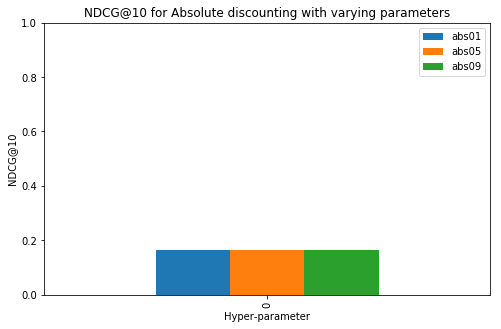

In [97]:
plot_ndcg_at_10_hp(['abs01', 'abs05', 'abs09'], "Absolute discounting")

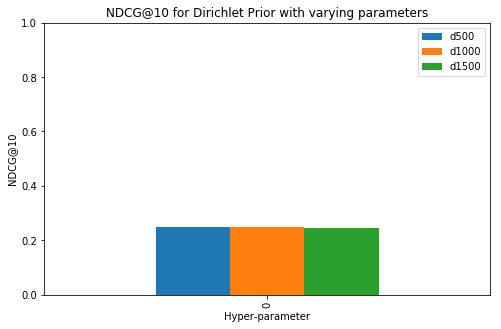

In [98]:
plot_ndcg_at_10_hp(['d500', 'd1000', 'd1500'], "Dirichlet Prior")

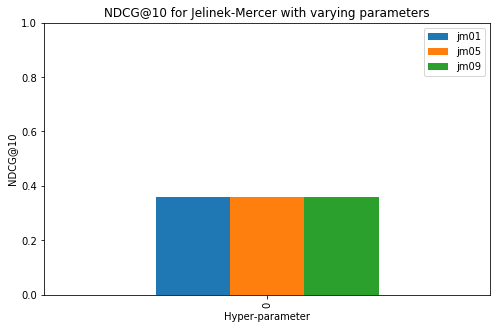

In [99]:
plot_ndcg_at_10_hp(['jm01', 'jm05', 'jm09'], "Jelinek-Mercer")

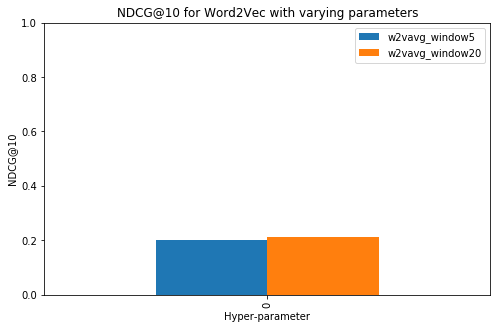

In [100]:
plot_ndcg_at_10_hp(['w2vavg_window5', 'w2vavg_window20'], "Word2Vec")

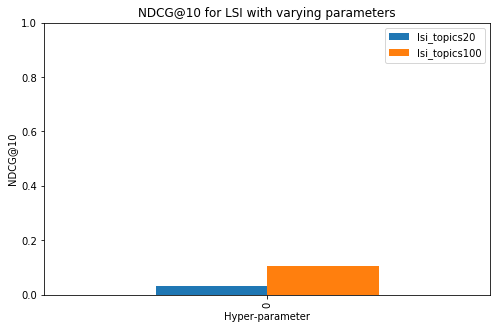

In [101]:
plot_ndcg_at_10_hp(['lsi_topics20', 'lsi_topics100'], "LSI")

### Visualization 

In [102]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

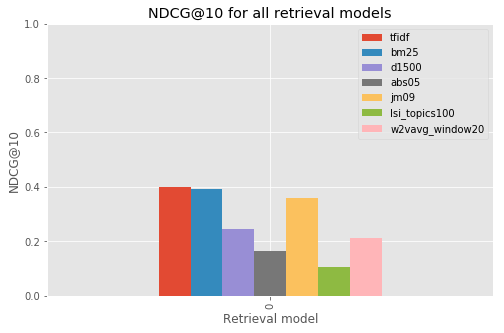

In [103]:
# TODO: check the average for each of the hyper-parameters per retrival model
title_ndcg_all = "NDCG@10 for all retrieval models"
ax = test_metrics_df[test_metrics_df['score'] == 'ndcg_cut_10'][list(test_metrics_df.columns)[1:]].plot(kind='bar',
                                                                                                   ylim=(0,1),
                                                                                                   figsize=(8,5),
                                                                                                   title=title_ndcg_all);

ax.set_xlabel("Retrieval model")
ax.set_ylabel("NDCG@10");

In [104]:
scores_test_df[scores_test_df['query_id'] == '196'].reset_index(drop=True)[4:5]

,d1000,score,query_id,tfidf,abs09,d1500,bm25,abs01,abs05,d500,lsi,jm01,jm05,jm09,w2vavg,w2vavg_window20,lsi_topics100
4,0.1357,ndcg_cut_10,196,0.469,0.0948,0.1357,0.4448,0.0948,0.0948,0.1357,0.0,0.359,0.359,0.359,0.0,0.0,0.0


In [105]:
scores_test_df[scores_test_df['query_id'] == '197'].reset_index(drop=True)[4:5]

,d1000,score,query_id,tfidf,abs09,d1500,bm25,abs01,abs05,d500,lsi,jm01,jm05,jm09,w2vavg,w2vavg_window20,lsi_topics100
4,0.1584,ndcg_cut_10,197,0.2809,0.0734,0.1488,0.4698,0.0734,0.0734,0.1584,0.0,0.3052,0.3149,0.3149,0.0,0.11,0.0


### Task 2: Latent Semantic Models (LSMs) [20 points] ###

In this task you will experiment with applying distributional semantics methods ([LSI](http://lsa3.colorado.edu/papers/JASIS.lsi.90.pdf) **[5 points]** and [LDA](https://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf) **[5 points]**) for retrieval.

You do not need to implement LSI or LDA on your own. Instead, you can use [gensim](http://radimrehurek.com/gensim/index.html). An example on how to integrate Pyndri with Gensim for word2vec can be found [here](https://github.com/cvangysel/pyndri/blob/master/examples/word2vec.py). For the remaining latent vector space models, you will need to implement connector classes (such as `IndriSentences`) by yourself.

In order to use a latent semantic model for retrieval, you need to:
   * build a representation of the query **q**,
   * build a representation of the document **d**,
   * calculate the similarity between **q** and **d** (e.g., cosine similarity, KL-divergence).
     
The exact implementation here depends on the latent semantic model you are using. 
   
Each of these LSMs come with various hyperparameters to tune. Make a choice on the parameters, and explicitly mention the reasons that led you to these decisions. You can use the validation set to optimize hyper parameters you see fit; motivate your decisions. In addition, mention clearly how the query/document representations were constructed for each LSM and explain your choices.

In this experiment, you will first obtain an initial top-1000 ranking for each query using TF-IDF in **Task 1**, and then re-rank the documents using the LSMs. Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

Perform significance testing **[5 points]** (similar as in Task 1) in the class of semantic matching methods.

Perform analysis **[5 points]**

In [106]:
import gensim
import pyndri.compat
from gensim import corpora, models, similarities

In [107]:
class IndriCorpus(gensim.interfaces.CorpusABC):

    def __init__(self, index, dictionary, max_documents=None):
        assert isinstance(index, pyndri.Index)

        self.index = index
        self.dictionary = dictionary

        self.max_documents = max_documents

    def _maximum_document(self):
        if self.max_documents is None:
            return self.index.maximum_document()
        else:
            return min(
                self.max_documents + self.index.document_base(),
                self.index.maximum_document())

    def __iter__(self):
        for int_doc_id in range(self.index.document_base(),
                                self._maximum_document()):
            ext_doc_id, tokens = self.index.document(int_doc_id)

            # Compared to IndriSentences, the only difference is the
            # switching of tuple(self.dictionary[token_id] ...) by
            # sorted(collections.Counter(token_id ...).items()).
            yield sorted(collections.Counter(
                token_id
                for token_id in tokens
                if token_id > 0 and token_id in self.dictionary).items())

In [108]:
# docs 1-1000
# index_models = [word_id for word_id in index.document(int(int_document_id))[1] if word_id > 0]
index_models = [index.document(int_doc) for int_doc in range(index.document_base(), index.document_base()+1000)]
# dictionary_models = pyndri.extract_dictionary(index_models)
# corpus_models = IndriCorpus(index_models, dictionary_models)

In [109]:
corpus = IndriCorpus(index, dictionary)

## LSI model

In [110]:
lsi_model = models.LsiModel(corpus=corpus, id2word=id2token, num_topics=20)
lsi_model.save('/tmp/model.lsi')

In [111]:
lsi_model = models.LsiModel.load('/tmp/model.lsi')

## LDA model

In [92]:
corpora.MmCorpus.serialize('corpus.mm', corpus)

In [93]:
mm = corpora.MmCorpus('corpus.mm')

In [112]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_models, id2word=id2token, num_topics=20, update_every=0, passes=20)
lda_model.save('/tmp/model.lda')

In [113]:
lda_model = models.LsiModel.load('/tmp/model.lda')

In [ ]:
"""
texts = []
for i in range (index.document_base(),index.maximum_document()):
    # texts[i-1] = ([id2token[word_id] for word_id in index.document(i)[1] if word_id > 0])
    texts.append([id2token[word_id] for word_id in index.document(i)[1] if word_id > 0])

len(texts)

# dictionary_corpus = corpora.Dictionary(texts)
# type(dictionary_corpus)

# get doc bow out of tokenized docs
# corpus_docs = [dictionary_corpus.doc2bow(text) for text in texts]

"""


#### Example LSI

In [114]:
# query
tokenized_queries['100']

[63065, 3063, 68, 1178]

In [115]:
query_tokens = [id2token[word_id] for word_id in tokenized_queries['100'] if word_id > 0]
query_tokens

['controlling', 'transfer', 'high', 'technology']

In [116]:
query_bow = dictionary.doc2bow(query_tokens)
query_bow

[(68, 1), (1178, 1), (3063, 1), (63065, 1)]

In [118]:
from scipy import spatial

def vec_query_lsm(query_id, model):
    query_tokens = [id2token[word_id] for word_id in tokenized_queries[str(query_id)] if word_id > 0]
    query_bow = dictionary.doc2bow(query_tokens)
    # infer topic distributions on new, unseen documents
    query_vec = [x[1] for x in model[query_bow]]
    return query_vec

def vec_doc_lsm(int_document_id, model):
    doc_tokens = [word_id for word_id in index.document(int(int_document_id))[1] if word_id > 0]
    # infer topic distributions on new, unseen documents
    doc_bow = dictionary.doc2bow(doc_tokens)
    doc_vec = [x[1] for x in model[doc_bow]]
    return doc_vec

def lsi(query_id, int_document_id):
    result = 1 - spatial.distance.cosine(vec_query_lsm(query_id, lsi_model), vec_doc_lsm(int_document_id, lsi_model))
    return result

def lda(query_id, int_document_id):
    result = 1 - spatial.distance.cosine(vec_query_lsm(query_id, lda_model), vec_doc_lsm(int_document_id, lda_model))
    return result

In [120]:
# lsi('100', 1)

In [121]:
# lda('100', 1)

In [123]:
# lsi.print_topics(num_topics=5, num_words=5)

In [124]:
# Text Analytics - Latent Semantic Analysis - https://www.youtube.com/watch?v=BJ0MnawUpaU
# https://radimrehurek.com/gensim/models/lsimodel.html
# https://radimrehurek.com/gensim/wiki.html
# Latent Semantic Analysis in Python - http://blog.josephwilk.net/projects/latent-semantic-analysis-in-python.html
# Building a Vector Space Search Engine in Python - http://blog.josephwilk.net/projects/building-a-vector-space-search-engine-in-python.html
# https://github.com/cvangysel/pyndri/blob/master/examples/word2vec.py
# integrate gensim and pyndri
# https://radimrehurek.com/gensim/tut2.html

### Task 3:  Word embeddings for ranking [10 points] ###

First create word embeddings on the corpus we provided using [word2vec](http://arxiv.org/abs/1411.2738) -- [gensim implementation](https://radimrehurek.com/gensim/models/word2vec.html). You should extract the indexed documents using pyndri and provide them to gensim for training a model (see example [here](https://github.com/nickvosk/pyndri/blob/master/examples/word2vec.py)).

Try one of the following (increasingly complex) methods for building query and document representations:
   * Average or sum the word vectors.
   * Cluster words in the document using [k-means](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) and use the centroid of the most important cluster. Experiment with different values of K for k-means.
   * Using the [bag-of-word-embeddings representation](https://ciir-publications.cs.umass.edu/pub/web/getpdf.php?id=1248).
   
Note that since we provide the implementation for training word2vec, you will be graded based on your creativity on combining word embeddings for building query and document representations.

Note: If you want to experiment with pre-trained word embeddings on a different corpus, you can use the word embeddings we provide alongside the assignment (./data/reduced_vectors_google.txt). These are the [google word2vec word embeddings](https://code.google.com/archive/p/word2vec/), reduced to only the words that appear in the document collection we use in this assignment.

In [127]:
logging.info('Initializing word2vec.')

word2vec_init = gensim.models.Word2Vec(
    size=20,  # Embedding size
    window=5,  # One-sided window size
    sg=True,  # Skip-gram.
    min_count=5,  # Minimum word frequency.
    sample=1e-3,  # Sub-sample threshold.
    hs=False,  # Hierarchical softmax.
    negative=10,  # Number of negative examples.
    iter=1,  # Number of iterations.
    workers=8,  # Number of workers.
)
with pyndri.open('index/') as index:
    logging.info('Loading vocabulary.')
    dictionary = pyndri.extract_dictionary(index)
    sentences = pyndri.compat.IndriSentences(index, dictionary)

    logging.info('Constructing word2vec vocabulary.')

    # Build vocab.
    word2vec_init.build_vocab(sentences, trim_rule=None)

    model = word2vec_init
    
    model.train(sentences,total_examples=model.corpus_count, epochs=2) 

    model.save('model_20')

logging.info('Trained models: %s', models)

In [128]:
w2v_model = gensim.models.Word2Vec.load('./word2vec_model/model_20')

In [129]:
def vec_query(query_id):
    query_vec = []
    for query_term_id in tokenized_queries[query_id]:
        term = id2token[query_term_id]
        try:
            vec = w2v_model[str(term)]
            query_vec.append(vec)
        except Exception:
            pass

    query_avg = np.mean(np.array(query_vec), axis = 0)
    
    return (query_avg)

def vec_doc(doc_id):
    doc_vec = []
    tokens = [id2token[word_id] for word_id in index.document(int(doc_id))[1] if word_id > 0]
    for term in tokens:
        try:
            vecs = w2v_model[str(term)]
            doc_vec.append(vecs)
        except Exception:
            pass

    doc_avg = np.mean(np.array(doc_vec), axis = 0)
    
    return (doc_avg)


def word2vec_similarity(query_id, doc_id, mode):
    if mode=='avg':
        result = 1 - spatial.distance.cosine(vec_query(query_id), vec_doc(doc_id))
        return result

### Task 4: Learning to rank (LTR) [10 points] ###

In this task you will get an introduction into learning to rank for information retrieval, in particular pointwise learning to rank.

You will experiment with a pointwise learning to rank method, logistic regression, implemented in [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
Train your LTR model using 10-fold cross validation on the test set.

You can explore different ways for devising features for the model. Obviously, you can use the retrieval methods you implemented in Task 1 and Task 2 as features. Think about other features you can use (e.g. query/document length). 
One idea is to also explore external sources such as Wikipedia entities (?). Creativity on devising new features and providing motivation for them will be taken into account when grading.

For every query, first create a document candidate set using the top-1000 documents using TF-IDF, and subsequently compute features given a query and a document. Note that the feature values of different retrieval methods are likely to be distributed differently.

how to get top 1000 docs per query?
('100, 1)
150.000 unique combinations

1. get unique combinations in a tuple (query-doc pair)
2. extract features from the scores_tuple
3. extract the y values?

In [132]:
ext_id_mapping = {}


for int_doc_id in range(index.document_base(), index.maximum_document()):
    ext_doc_id, doc_token_ids = index.document(int_doc_id)
    ext_id_mapping[ext_doc_id] = int_doc_id
    
ext_id_mapping_df = pd.DataFrame.from_dict(list(ext_id_mapping.items()))
ext_id_mapping_df.columns = ['ext_id', 'doc_id']
ext_id_mapping_df.head()

,ext_id,doc_id
0,AP890613-0142,5418
1,AP890109-0145,75567
2,AP890711-0026,66602
3,AP891210-0079,57384
4,AP880711-0188,153749


In [133]:
import pandas as pd
column_names_w2v = ["q_id", "Q0", "ext_doc_id", "no", "w2vavg", "label"]
column_names_lsi = ["q_id", "Q0", "ext_doc_id", "no", "lsi", "label"]
ext_id_mapping_df = pd.DataFrame(list(ext_id_mapping.items()))
ext_id_mapping_df.columns = ['ext_doc_id', 'doc_id']
ext_id_mapping_df.head()

,ext_doc_id,doc_id
0,AP890613-0142,5418
1,AP890109-0145,75567
2,AP890711-0026,66602
3,AP891210-0079,57384
4,AP880711-0188,153749


In [134]:
w2v_df = pd.read_csv("./run_files/w2vavg.run", sep=" ", header = None, names = column_names_w2v)
w2v_df.drop(['Q0'], axis = 1, inplace = True)
w2v_df.drop(['no'], axis = 1, inplace = True)
w2v_df.drop(['label'], axis = 1, inplace = True)
w2v_df = pd.merge(w2v_df, ext_id_mapping_df, on='ext_doc_id', how='inner')
w2v_df.drop(['ext_doc_id'], axis = 1, inplace = True)
w2v_df.head()

,q_id,w2vavg,doc_id
0,135,0.961937,157251
1,96,0.906553,157251
2,104,0.803652,157251
3,196,0.937796,157251
4,172,0.925975,157251


In [135]:
len(w2v_df['doc_id'].unique())

68056

In [136]:
len(w2v_df['q_id'].unique())

150

In [137]:
lsi_df = pd.read_csv("./run_files/lsi.run", sep=" ", header = None, names = column_names_lsi)
lsi_df.drop(['Q0'], axis = 1, inplace = True)
lsi_df.drop(['no'], axis = 1, inplace = True)
lsi_df.drop(['label'], axis = 1, inplace = True)
lsi_df = pd.merge(lsi_df, ext_id_mapping_df, on='ext_doc_id', how='inner')
lsi_df.drop(['ext_doc_id'], axis = 1, inplace = True)
lsi_df.head()

,q_id,lsi,doc_id
0,135,0.955262,43209
1,98,0.672555,43209
2,109,0.776466,43209
3,135,0.954215,60543
4,153,0.861102,60543


In [140]:
w2v_lsi_df = pd.merge(lsi_df, w2v_df, on=('q_id', 'doc_id'), how='left')
len(w2v_lsi_df)

145681

### Features

In [142]:
X = pd.DataFrame()
for feature in [str(key) for key in scores_dict.keys()]:
    X[feature] = scores_dict[feature]

X['query_id'] = [q_doc_p[0] for q_doc_p in query_doc_pairs]
X['doc_id'] = [q_doc_p[1] for q_doc_p in query_doc_pairs]
query_doc_pairs = list(scores_tuple.keys())

X.head()

### Validation target values

In [143]:
import pandas as pd
import csv
with open('ap_88_89/qrel_validation', 'r') as inpt:
    reader = list(csv.reader(inpt,delimiter=' '))
    # print (reader)
    
y_val = pd.DataFrame(reader)
y_val.columns = ['query_id', '0', 'ext_id', 'rel']
y_val = y_val.merge(ext_id_mapping_df)
y_val.drop(columns=['0', 'ext_id'], inplace=True)
y_val.head()

### Test target values

In [144]:
with open('ap_88_89/qrel_test', 'r') as inpt:
    reader = list(csv.reader(inpt,delimiter=' '))
    # print (reader)
    
y_test = pd.DataFrame(reader)
y_test.columns = ['query_id', '0', 'ext_id', 'rel']
y_test = y_test.merge(ext_id_mapping_df)
y_test.drop(columns=['0', 'ext_id'], inplace=True)
y_test.head()

In [145]:
# http://nbviewer.jupyter.org/gist/justmarkham/6d5c061ca5aee67c4316471f8c2ae976

In [146]:
X_updated = pd.merge(X, y_test, left_on=['doc_id', 'query_id'], right_on=['doc_id', 'query_id'], how='left')
X_updated['rel'].value_counts()

In [148]:
X_updated['rel'].value_counts()[1] / (X_updated['rel'].value_counts()[1] + X_updated['rel'].value_counts()[0])
X_updated.dropna(inplace=True)

In [149]:
X_updated['rel'].value_counts()[1] / (X_updated['rel'].value_counts()[1] + X_updated['rel'].value_counts()[0])

In [150]:
X_updated.reset_index(inplace=True, drop=True)
X_updated['rel'].unique()
X_updated.drop(['query_id', 'doc_id', 'abs_discounting05', 'abs_discounting09', 'dirichlet1000', 'dirichlet1500'], inplace=True, axis=1)

In [151]:
X_updated.head()

In [152]:
X = X_updated.loc[:, X_updated.columns != 'rel']
y = X_updated['rel']

In [153]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold

## Building the model

### Method 1

In [381]:
from sklearn import metrics, cross_validation
from sklearn.cross_validation import cross_val_score

# predicted = cross_validation.cross_val_predict(LogisticRegression(), X, y, cv=10)
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print(scores)

[ 0.69649908  0.69702553  0.69623585  0.69755199  0.69781521  0.69702553
  0.69676231  0.69649908  0.69720906  0.69694576]


In [388]:
scores.mean()

0.69695694011103781

### Method 2

In [384]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [385]:
predicted = clf.predict(X_test)

In [387]:
print(metrics.accuracy_score(y_test, predicted))

0.700096516627


In [389]:
print(metrics.classification_report(y_test, predicted))

             precision    recall  f1-score   support

          0       0.70      1.00      0.82      7978
          1       0.53      0.00      0.00      3419

avg / total       0.65      0.70      0.58     11397



In [394]:
pd.Series(predicted).value_counts()

0    11382
1       15
dtype: int64

### Task 4: Write a report [20 points; instant FAIL if not provided] ###

The report should be a PDF file created using the [sigconf ACM template](https://www.acm.org/publications/proceedings-template) and will determine a significant part of your grade.

   * It should explain what you have implemented, motivate your experiments and detail what you expect to learn from them. **[10 points]**
   * Lastly, provide a convincing analysis of your results and conclude the report accordingly. **[10 points]**
      * Do all methods perform similarly on all queries? Why?
      * Is there a single retrieval model that outperforms all other retrieval models (i.e., silver bullet)?
      * ...

**Hand in the report and your self-contained implementation source files.** Only send us the files that matter, organized in a well-documented zip/tgz file with clear instructions on how to reproduce your results. That is, we want to be able to regenerate all your results with minimal effort. You can assume that the index and ground-truth information is present in the same file structure as the one we have provided.
